### Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
url = "https://raw.githubusercontent.com/saptarshihalder/Market_Campaign_Analysis/refs/heads/main/marketing_campaign_fixed.csv"
data = pd.read_csv(url)
print(data.head())
print(data.info())
print(data.describe())


     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

### Feature Engineering

In [ ]:
# Creating new features
CURRENT_YEAR = 2024
data['Age'] = CURRENT_YEAR - data['Year_Birth']
data['Total_Campaigns'] = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
data['Total_Spend'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
data['Average_Spend'] = data['Total_Spend'] / (data['Total_Campaigns'] + 1)
data['Is_Parent'] = ((data['Kidhome'] + data['Teenhome']) > 0).astype(int)

# Encoding categorical variables
data = pd.get_dummies(data, columns=['Education', 'Marital_Status'], drop_first=True)


### Exploratory Data Analysis (EDA)

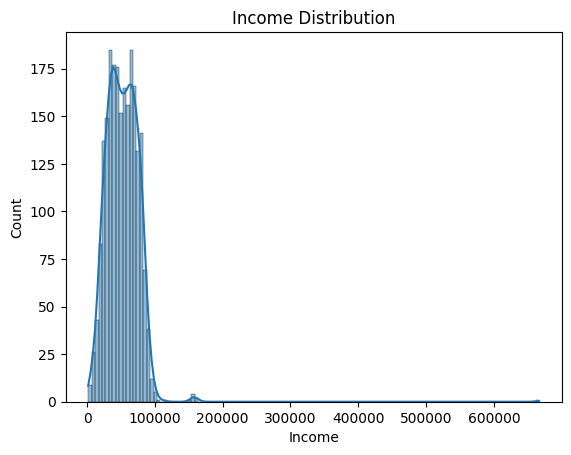

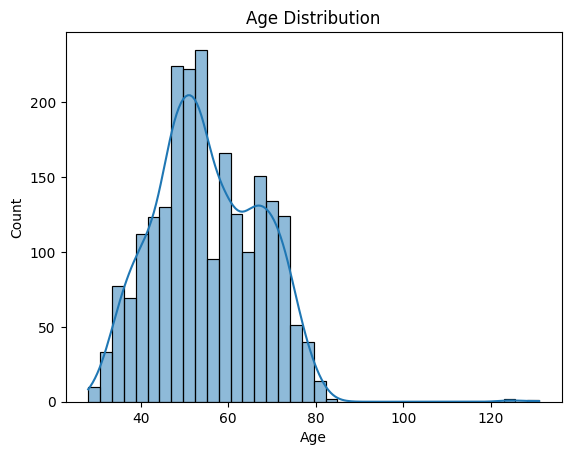

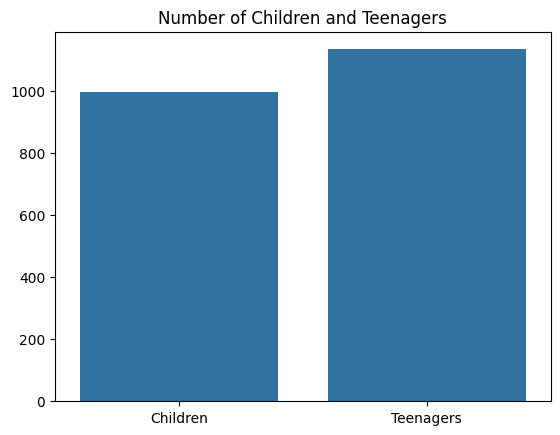

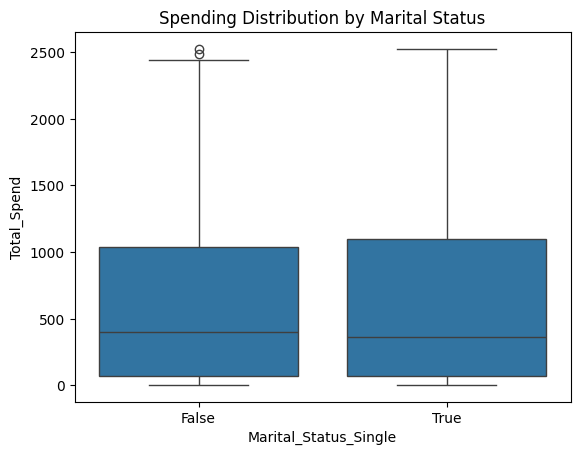

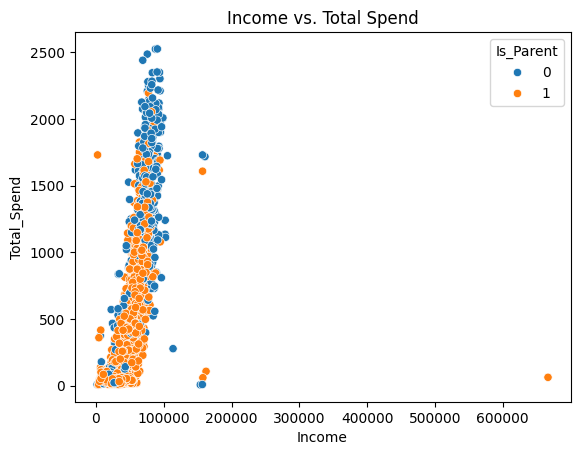

In [ ]:
# Distribution plots
sns.histplot(data['Income'], kde=True)
plt.title("Income Distribution")
plt.show()

sns.histplot(data['Age'], kde=True)
plt.title("Age Distribution")
plt.show()

# Number of children and teenagers in a household
sns.barplot(x=['Children', 'Teenagers'], y=[data['Kidhome'].sum(), data['Teenhome'].sum()])
plt.title("Number of Children and Teenagers")
plt.show()

# Spending distribution by marital status
sns.boxplot(x='Marital_Status_Single', y='Total_Spend', data=data)
plt.title("Spending Distribution by Marital Status")
plt.show()

# Scatter plot example
sns.scatterplot(x='Income', y='Total_Spend', hue='Is_Parent', data=data)
plt.title("Income vs. Total Spend")
plt.show()


### Feature Selection

Non-numeric columns: Index(['Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')


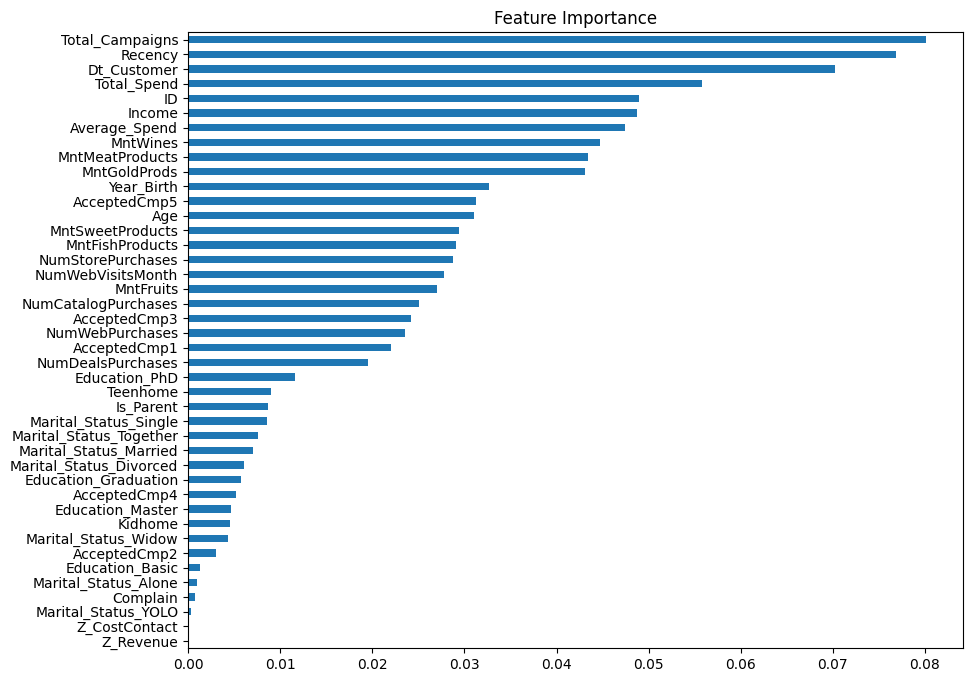

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non-numeric features
for col in data.select_dtypes(include=['object']).columns:
    if data[col].nunique() <= 10:  # For categorical columns with limited unique values
        data = pd.get_dummies(data, columns=[col], drop_first=True)
    else:  # For columns with many unique values, use Label Encoding
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

# Ensure all columns are numeric before feature importance
X = data.drop(columns=['Response'], errors='ignore')  # Drop target column
y = data['Response']

# Check for non-numeric columns
print("Non-numeric columns:", X.select_dtypes(exclude=[np.number]).columns)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest for feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Plot feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance")
plt.show()


### Model Training and Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import plotly.figure_factory as ff
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.2f}\n")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_labels = ['Class 0', 'Class 1']  # Modify if your dataset has more classes

    # Create a Plotly heatmap for the confusion matrix
    fig = ff.create_annotated_heatmap(
        z=cm,
        x=cm_labels,
        y=cm_labels,
        colorscale='Viridis',
        showscale=True
    )
    fig.update_layout(
        title=f"Confusion Matrix: {name}",
        xaxis_title="Predicted Label",
        yaxis_title="True Label"
    )
    fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.85
Precision: 0.54
Recall: 0.20
F1 Score: 0.29



Model: Decision Tree
Accuracy: 0.80
Precision: 0.37
Recall: 0.38
F1 Score: 0.37



Model: Random Forest
Accuracy: 0.87
Precision: 0.65
Recall: 0.29
F1 Score: 0.40



Model: Gradient Boosting
Accuracy: 0.88
Precision: 0.75
Recall: 0.30
F1 Score: 0.43

